In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
# !pip install xgboost-gpu

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# !pip install --upgrade xgboost

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import shutil
from git import Repo, Actor
from kaggle_secrets import UserSecretsClient # Untuk mengakses Kaggle Secrets
import sqlite3 # Modul untuk berinteraksi dengan database SQLite

# --- Konfigurasi (Sesuaikan dengan milik Anda) ---
# Nama pengguna GitHub Anda (bisa juga disimpan sebagai secret)
# GITHUB_USERNAME =  # Pastikan ini di-set, misal dari secret
# Nama repositori Anda (misalnya, "nama-repo-privat-saya")
REPO_NAME = "DataQuest"

# Nama berkas database SQLite yang ingin di-load/ubah dari GitHub
# (path relatif di dalam repo)
DATABASE_FILE_NAME_IN_REPO = "optuna_study3.db" # Ganti dengan nama berkas Anda

# Pesan commit
COMMIT_MESSAGE = f"Update database {os.path.basename(DATABASE_FILE_NAME_IN_REPO)} from Kaggle Notebook"

# Nama branch yang akan digunakan
BRANCH_NAME = "main" # atau "master", sesuaikan dengan repo Anda

# Direktori lokal di Kaggle untuk clone repo
LOCAL_REPO_PATH = f"/kaggle/working/{REPO_NAME}"

# --- Dapatkan Kredensial dari Kaggle Secrets ---
try:
    user_secrets = UserSecretsClient()
    GITHUB_PAT = user_secrets.get_secret("GITHUB_PAT")
    GITHUB_USERNAME = user_secrets.get_secret("GITHUB_USERNAME") # Pastikan Anda punya secret ini
    # GITHUB_EMAIL = user_secrets.get_secret("GITHUB_EMAIL") # Opsional, untuk git config
    # GITHUB_DISPLAY_NAME = user_secrets.get_secret("GITHUB_DISPLAY_NAME") # Opsional, untuk git config
except Exception as e:
    print(f"Error mengakses Kaggle Secrets: {e}")
    print("Pastikan Anda telah menambahkan GITHUB_PAT dan GITHUB_USERNAME ke Kaggle Secrets.")
    raise

# --- URL Repositori dengan Autentikasi PAT ---
authenticated_repo_url = f"https://{GITHUB_PAT}@github.com/{GITHUB_USERNAME}/{REPO_NAME}.git"

# --- Fungsi untuk Setup Git User (Penting untuk Commit) ---
def set_git_config(repo_instance):
    """Mengatur konfigurasi nama dan email pengguna Git untuk repositori."""

    # Coba dapatkan GITHUB_EMAIL dari secrets, jika tidak ada, gunakan default
    try:
        email = user_secrets.get_secret("GITHUB_EMAIL")
        print("Menggunakan GITHUB_EMAIL dari Kaggle Secrets.")
    except Exception: # Lebih spesifik bisa BackendError jika tahu itu yang dimunculkan
        email = "kaggle-notebook@example.com" # Default jika secret tidak ditemukan
        print("Secret GITHUB_EMAIL tidak ditemukan, menggunakan email default.")

    # Coba dapatkan GITHUB_DISPLAY_NAME dari secrets, jika tidak ada, gunakan default
    try:
        name = user_secrets.get_secret("GITHUB_DISPLAY_NAME")
        print("Menggunakan GITHUB_DISPLAY_NAME dari Kaggle Secrets.")
    except Exception: # Lebih spesifik bisa BackendError
        name = "Kaggle Notebook Runner"     # Default jika secret tidak ditemukan
        print("Secret GITHUB_DISPLAY_NAME tidak ditemukan, menggunakan nama default.")

    try:
        with repo_instance.config_writer() as git_config:
            git_config.set_value("user", "email", email)
            git_config.set_value("user", "name", name)
        print(f"Git user.email ('{email}') dan user.name ('{name}') telah diatur untuk repo ini.")
    except Exception as e:
        print(f"Error saat mengatur git config: {e}")

# --- 1. Clone atau Paksa Sinkronisasi Repositori Lokal dari GitHub ---
repo = None
path_ke_database_lokal = None # Akan diisi setelah clone/sinkronisasi berhasil

try:
    if os.path.exists(LOCAL_REPO_PATH):
        print(f"Direktori repositori lokal ditemukan di {LOCAL_REPO_PATH}.")
        print(f"PERINGATAN: Akan menimpa repositori lokal agar sesuai dengan remote 'origin/{BRANCH_NAME}'.")
        print("SEMUA PERUBAHAN LOKAL YANG BELUM DI-PUSH AKAN HILANG.")
        repo = Repo(LOCAL_REPO_PATH)

        # Pastikan URL remote 'origin' menggunakan PAT untuk otentikasi
        origin = repo.remote(name='origin')
        current_origin_url = origin.url
        if GITHUB_PAT not in current_origin_url and GITHUB_USERNAME not in current_origin_url.split('@')[0].split('//')[-1] :
            print(f"PAT tidak terdeteksi di URL remote saat ini ({current_origin_url}). Mengupdate remote origin...")
            repo.delete_remote('origin')
            origin = repo.create_remote('origin', authenticated_repo_url) # Update variabel origin
            print("URL remote origin telah diupdate dengan PAT.")
        
        try:
            print(f"\nMemulai proses untuk menimpa repositori lokal dengan kondisi dari remote 'origin/{BRANCH_NAME}'...")

            # 1. Fetch semua informasi terbaru dari remote 'origin'
            print(f"Langkah 1: Melakukan fetch semua perubahan dari remote 'origin'...")
            origin.fetch()
            print("Fetch dari remote 'origin' selesai.")

            # Nama referensi branch remote yang akan dijadikan acuan
            remote_branch_ref = f"origin/{BRANCH_NAME}"
            print(f"Langkah 2: Akan me-reset branch lokal '{BRANCH_NAME}' ke kondisi '{remote_branch_ref}'.")

            # (Opsional) Pastikan kita berada di branch yang benar sebelum reset
            if repo.active_branch.name != BRANCH_NAME:
                print(f"  Info: Branch aktif saat ini adalah '{repo.active_branch.name}'. Melakukan checkout ke '{BRANCH_NAME}'...")
                try:
                    repo.git.checkout(BRANCH_NAME)
                    print(f"  Berhasil checkout ke branch '{BRANCH_NAME}'.")
                except Exception as e_checkout:
                    # Jika checkout gagal (misalnya karena ada uncommitted changes yang konflik),
                    # reset --hard mungkin masih bisa berjalan, tapi ini adalah kondisi yang kurang ideal.
                    print(f"  Peringatan: Gagal checkout ke branch '{BRANCH_NAME}' ({e_checkout}). Melanjutkan reset dengan target '{remote_branch_ref}'.")

            # 2. Reset (timpa) branch lokal agar sama persis dengan branch remote
            print(f"Langkah 3: Melakukan 'git reset --hard {remote_branch_ref}'...")
            repo.git.reset('--hard', remote_branch_ref)
            print(f"Repositori lokal (branch '{BRANCH_NAME}') telah berhasil di-reset (ditimpa) sesuai dengan '{remote_branch_ref}'.")

            # 3. Membersihkan file dan direktori yang tidak dilacak (untracked)
            print("Langkah 4: Membersihkan file dan direktori yang tidak dilacak (untracked)...")
            repo.git.clean('-fd') # -f untuk file, -d untuk direktori. Gunakan -fdx jika ingin menghapus file yang di-ignore juga.
            print("Pembersihan file dan direktori yang tidak dilacak selesai.")

            print(f"\nRepositori lokal di '{LOCAL_REPO_PATH}' telah berhasil disinkronkan (ditimpa) dengan 'origin/{BRANCH_NAME}'.")

        except Exception as e_overwrite:
            print(f"Error saat mencoba menimpa repositori lokal: {e_overwrite}")
            raise # Naikkan error agar skrip berhenti jika proses penimpaan gagal

    else:
        print(f"Direktori repositori lokal TIDAK ditemukan. Melakukan clone repositori dari {GITHUB_USERNAME}/{REPO_NAME} ke {LOCAL_REPO_PATH}...")
        repo = Repo.clone_from(authenticated_repo_url, LOCAL_REPO_PATH, branch=BRANCH_NAME)
        print("Clone berhasil.")

    # Pastikan kita berada di branch yang benar setelah clone atau reset
    if repo.active_branch.name != BRANCH_NAME:
        print(f"Switching atau memastikan berada di branch {BRANCH_NAME}...")
        repo.git.checkout(BRANCH_NAME)
    
    set_git_config(repo)
    
    # Path lengkap ke berkas database di dalam repositori lokal yang sudah di-clone/disinkronkan
    path_ke_database_lokal = os.path.join(LOCAL_REPO_PATH, DATABASE_FILE_NAME_IN_REPO)

    if not os.path.exists(path_ke_database_lokal):
        print(f"PERHATIAN: Berkas database '{DATABASE_FILE_NAME_IN_REPO}' tidak ditemukan di '{path_ke_database_lokal}' setelah clone/sinkronisasi.")
        # Anda mungkin ingin menghentikan skrip di sini jika file DB adalah krusial dan tidak ditemukan
        # raise FileNotFoundError(f"Berkas database tidak ditemukan: {path_ke_database_lokal}")

except Exception as e:
    print(f"Error utama pada tahap clone atau sinkronisasi repositori: {e}")
    if "Authentication failed" in str(e):
        print("Pastikan GITHUB_PAT dan GITHUB_USERNAME sudah benar dan PAT memiliki izin 'repo'.")
    if os.path.exists(LOCAL_REPO_PATH) and repo is None: # Jika ada direktori tapi repo gagal diinisialisasi
        print(f"Menghapus direktori yang mungkin gagal diinisialisasi atau korup: {LOCAL_REPO_PATH}")
        shutil.rmtree(LOCAL_REPO_PATH) # Hati-hati dengan ini
    raise


# --- 2. Baca dan Ubah Berkas Database SQLite ---
# (Sisa kode Anda dari sini ke bawah tetap sama)
# Pastikan path_ke_database_lokal sudah terdefinisi dan berkasnya ada
if path_ke_database_lokal and os.path.exists(path_ke_database_lokal):
    print(f"Mengakses database SQLite di: {path_ke_database_lokal}")
    conn = None # Inisialisasi koneksi di luar try-finally
    try:
        # Hubungkan ke database SQLite
        conn = sqlite3.connect(path_ke_database_lokal)
        cursor = conn.cursor()

        # --- CONTOH OPERASI PADA DATABASE ---
        # A. Membaca data (contoh)
        print("\nMembaca data contoh dari tabel 'nama_tabel_anda'...")
        try:
            cursor.execute("SELECT * FROM nama_tabel_anda LIMIT 5;") # GANTI 'nama_tabel_anda'
            rows = cursor.fetchall()
            if rows:
                for row in rows:
                    print(row)
            else:
                print("Tidak ada data di 'nama_tabel_anda' atau tabel tidak ada.")
        except sqlite3.Error as er_read:
            print(f"Error saat membaca dari tabel: {er_read}")
            print("Pastikan 'nama_tabel_anda' sudah benar dan ada di database.")


        # B. Mengubah data (contoh: INSERT atau UPDATE)
        # Ganti bagian ini dengan logika perubahan database Anda yang sebenarnya
        print("\nMelakukan perubahan pada database (contoh INSERT)...")
        try:
            # Contoh: Menambahkan data baru ke tabel 'nama_tabel_anda'
            # Sesuaikan nama tabel dan kolom dengan struktur database Anda
            cursor.execute("""
                INSERT INTO nama_tabel_anda (kolom1, kolom2) 
                VALUES (?, ?);
            """, ("nilai_baru_1_dari_kaggle", "nilai_baru_2_dari_kaggle")) # GANTI DENGAN DATA ANDA
            
            # Atau contoh UPDATE:
            # cursor.execute("""
            #     UPDATE nama_tabel_anda
            #     SET kolom1 = ?
            #     WHERE kolom_kondisi = ?;
            # """, ("nilai_update", "kondisi_tertentu"))


            # Penting: Commit perubahan di dalam transaksi SQLite
            conn.commit()
            print("Perubahan pada database berhasil di-commit (transaksi SQLite).")

        except sqlite3.Error as er_write:
            print(f"Error saat mengubah data di database: {er_write}")
            print("Pastikan query SQL Anda benar dan tabel/kolom ada.")


        # --- AKHIR CONTOH OPERASI ---

    except sqlite3.Error as e:
        print(f"Error saat berinteraksi dengan database SQLite: {e}")
    finally:
        # Penting: Selalu tutup koneksi ke database
        if conn:
            conn.close()
            print("Koneksi ke database SQLite ditutup.")
else:
    if not path_ke_database_lokal:
        print("Path ke database lokal tidak terdefinisi. Lewati operasi database.")
    else:
        print(f"Berkas database SQLite tidak ditemukan di {path_ke_database_lokal}. Operasi database dilewati.")

# --- BAGIAN UNTUK COMMIT DAN PUSH (Tidak diubah, tambahkan jika belum ada dari respons sebelumnya) ---
# Jika Anda ingin menambahkan bagian commit dan push setelah ini,
# Anda bisa menyalinnya dari respons saya sebelumnya yang fokus pada commit dan push.
# Contoh:
# if repo: 
#     # ... logika add, commit, push ...

print("\nSkrip selesai.")

Direktori repositori lokal TIDAK ditemukan. Melakukan clone repositori dari Dimassaputra5/DataQuest ke /kaggle/working/DataQuest...
Clone berhasil.
Secret GITHUB_EMAIL tidak ditemukan, menggunakan email default.
Secret GITHUB_DISPLAY_NAME tidak ditemukan, menggunakan nama default.
Git user.email ('kaggle-notebook@example.com') dan user.name ('Kaggle Notebook Runner') telah diatur untuk repo ini.
Mengakses database SQLite di: /kaggle/working/DataQuest/optuna_study3.db

Membaca data contoh dari tabel 'nama_tabel_anda'...
Error saat membaca dari tabel: no such table: nama_tabel_anda
Pastikan 'nama_tabel_anda' sudah benar dan ada di database.

Melakukan perubahan pada database (contoh INSERT)...
Error saat mengubah data di database: no such table: nama_tabel_anda
Pastikan query SQL Anda benar dan tabel/kolom ada.
Koneksi ke database SQLite ditutup.

Skrip selesai.


In [3]:
data = '/kaggle/working/DataQuest/training_dataset.csv'
data_validation = '/kaggle/working/DataQuest/validation_set.csv'
cc = pd.read_csv(data, 
                 encoding='utf-8',
                 sep=',')
cc_validation = pd.read_csv(data_validation, 
                 encoding='utf-8',
                 sep=',')
cc

,customer_number,usia,pekerjaan,status_perkawinan,pendidikan,gagal_bayar_sebelumnya,pinjaman_rumah,pinjaman_pribadi,jenis_kontak,bulan_kontak_terakhir,...,hari_sejak_kontak_sebelumnya,jumlah_kontak_sebelumnya,hasil_kampanye_sebelumnya,tingkat_variasi_pekerjaan,indeks_harga_konsumen,indeks_kepercayaan_konsumen,suku_bunga_euribor_3bln,jumlah_pekerja,pulau,berlangganan_deposito
0,531036,63,sosial media specialis,menikah,Pendidikan Tinggi,no,yes,no,cellular,jul,...,999,0,nonexistent,-1.7,94.215,-40.3,0.885,4991.6,Papua,1
1,999241,43,teknisi,menikah,Pendidikan Tinggi,no,yes,no,cellular,nov,...,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,Sulawesi,0
2,995002,29,sosial media specialis,lajang,Pendidikan Tinggi,no,yes,yes,cellular,jul,...,999,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1,Papua,0
3,932750,40,pekerja kasar,menikah,SMA,no,no,no,telephone,may,...,999,0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,Sumatera,1
4,684699,40,sosial media specialis,lajang,Pendidikan Tinggi,no,no,no,cellular,aug,...,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,Bali,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22911,680377,32,teknisi,menikah,Diploma,no,yes,no,cellular,aug,...,999,0,nonexistent,1.4,93.444,-36.1,4.967,5228.1,Kalimantan,0
22912,505429,30,mahasiswa,lajang,Diploma,no,no,no,telephone,sep,...,999,0,nonexistent,-1.1,94.199,-37.5,0.880,4963.6,Bali,0
22913,308952,29,manajer,lajang,SMA,no,yes,no,cellular,jul,...,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,NTT,0
22914,865813,52,entrepreneur,menikah,Tidak Tamat SD,unknown,yes,no,telephone,jun,...,999,0,nonexistent,1.4,94.465,-41.8,4.960,5228.1,NTB,0


In [4]:
cc_validation

,customer_number,usia,pekerjaan,status_perkawinan,pendidikan,gagal_bayar_sebelumnya,pinjaman_rumah,pinjaman_pribadi,jenis_kontak,bulan_kontak_terakhir,...,jumlah_kontak_kampanye_ini,hari_sejak_kontak_sebelumnya,jumlah_kontak_sebelumnya,hasil_kampanye_sebelumnya,tingkat_variasi_pekerjaan,indeks_harga_konsumen,indeks_kepercayaan_konsumen,suku_bunga_euribor_3bln,jumlah_pekerja,pulau
0,445420,35,penyedia jasa,menikah,SMA,no,yes,yes,cellular,jul,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,Jawa
1,585604,52,teknisi,lajang,Diploma,unknown,no,no,telephone,may,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,Papua
2,888824,37,pekerja kasar,menikah,SMP,unknown,yes,no,telephone,may,...,3,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,Bali
3,816820,51,pengangguran,menikah,Diploma,no,no,no,telephone,may,...,3,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,Sumatera
4,542716,45,teknisi,cerai,SMA,no,yes,no,cellular,may,...,1,999,1,failure,-1.8,92.893,-46.2,1.327,5099.1,Sumatera
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5724,782072,51,pekerja kasar,menikah,Tidak Tamat SD,no,yes,no,telephone,jun,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,Kalimantan
5725,116371,30,pekerja kasar,menikah,SMP,no,yes,yes,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,Sulawesi
5726,773759,45,pekerja kasar,menikah,SMP,unknown,yes,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,NTB
5727,612330,60,teknisi,menikah,Diploma,unknown,no,no,telephone,jul,...,15,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,Papua


In [5]:
cc.info()
cc_validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22916 entries, 0 to 22915
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_number               22916 non-null  int64  
 1   usia                          22916 non-null  int64  
 2   pekerjaan                     22916 non-null  object 
 3   status_perkawinan             22916 non-null  object 
 4   pendidikan                    22916 non-null  object 
 5   gagal_bayar_sebelumnya        22916 non-null  object 
 6   pinjaman_rumah                22916 non-null  object 
 7   pinjaman_pribadi              22916 non-null  object 
 8   jenis_kontak                  22916 non-null  object 
 9   bulan_kontak_terakhir         22916 non-null  object 
 10  hari_kontak_terakhir          22916 non-null  object 
 11  jumlah_kontak_kampanye_ini    22916 non-null  int64  
 12  hari_sejak_kontak_sebelumnya  22916 non-null  int64  
 13  j

In [6]:
cc.isnull().sum()

customer_number                 0
usia                            0
pekerjaan                       0
status_perkawinan               0
pendidikan                      0
gagal_bayar_sebelumnya          0
pinjaman_rumah                  0
pinjaman_pribadi                0
jenis_kontak                    0
bulan_kontak_terakhir           0
hari_kontak_terakhir            0
jumlah_kontak_kampanye_ini      0
hari_sejak_kontak_sebelumnya    0
jumlah_kontak_sebelumnya        0
hasil_kampanye_sebelumnya       0
tingkat_variasi_pekerjaan       0
indeks_harga_konsumen           0
indeks_kepercayaan_konsumen     0
suku_bunga_euribor_3bln         0
jumlah_pekerja                  0
pulau                           0
berlangganan_deposito           0
dtype: int64

# EDA

In [7]:
# sns.set(style="whitegrid")
# plt.rcParams["figure.figsize"] = (10, 6)

# print(cc.describe())
# print(cc.describe(include='object'))
# print(cc.isnull().sum())
# print(cc.duplicated().sum())

In [8]:
# num_cols = cc.select_dtypes(include=np.number).columns
# for col in num_cols:
#     sns.histplot(cc[col], kde=True)
#     plt.title(f'Distribusi: {col}')
#     plt.show()

In [9]:
# cat_cols = cc.select_dtypes(include="object").columns
# for col in cat_cols:
#     sns.countplot(x=col, data=cc)
#     plt.title(f'Frekuensi: {col}')
#     plt.xticks(rotation=45)
#     plt.show()

In [10]:
# corr = cc.corr(numeric_only=True)
# sns.heatmap(corr, annot=True, cmap="coolwarm")
# plt.title("Heatmap Korelasi")
# plt.show()

In [11]:
# for col in num_cols:
#     sns.boxplot(x=cc[col])
#     plt.title(f'Outlier check: {col}')
#     plt.show()

# Feature Enginering

In [12]:
print(cc['usia'].describe())
label_usia = ['remaja', 'dewasa muda', 'dewasa mapan', 'pra-pensuin', 'pensiunan', 'lansia lanjut']
variabelusia = 'usia'
bins = [17, 25, 35, 55, 65, 75, cc['usia'].max()]
cc['usia_binning'] = pd.cut(
    cc['usia'], 
    bins=bins,
    labels=label_usia,
    right=False,
    include_lowest=True,
    duplicates='drop'
)
cc['usia_binning'] = cc['usia_binning'].astype('category').cat.codes
cc = cc.dropna()
################################################################################
cc_validation['usia_binning'] = pd.cut(
    cc['usia'], 
    bins=bins,
    labels=label_usia,
    right=False,
    include_lowest=True,
    duplicates='drop'
)
cc_validation['usia_binning'] = cc_validation['usia_binning'].astype('category').cat.codes
cc_validation = cc_validation.dropna()


count    22916.000000
mean        40.016233
std         10.438059
min         17.000000
25%         32.000000
50%         38.000000
75%         47.000000
max         98.000000
Name: usia, dtype: float64


In [13]:
cc['bulan_kontak_terakhir'] = cc['bulan_kontak_terakhir'].map({
    'jul': 7, 'nov': 11, 'may': 5, 'aug': 8, 'oct': 10, 'apr': 4, 'jun': 6, 'sep': 9, 'mar': 3, 'dec':12
}).astype(int)
cc['bulan_sin'] = np.sin(2 * np.pi * cc['bulan_kontak_terakhir'] / 12 )
cc['bulan_cos'] = np.cos(2 * np.pi * cc['bulan_kontak_terakhir'] / 12 )
cc = cc.drop(['bulan_kontak_terakhir'], axis = 1)
#####################################################################
cc_validation['bulan_kontak_terakhir'] = cc_validation['bulan_kontak_terakhir'].map({
    'jul': 7, 'nov': 11, 'may': 5, 'aug': 8, 'oct': 10, 'apr': 4, 'jun': 6, 'sep': 9, 'mar': 3, 'dec':12
}).astype(int)
cc_validation['bulan_sin'] = np.sin(2 * np.pi * cc_validation['bulan_kontak_terakhir'] / 12 )
cc_validation['bulan_cos'] = np.cos(2 * np.pi * cc_validation['bulan_kontak_terakhir'] / 12 )
cc_validation = cc_validation.drop(['bulan_kontak_terakhir'], axis = 1)


In [14]:
cc['hari_kontak_terakhir'].unique()
cc['hari_kontak_terakhir'] = cc['hari_kontak_terakhir'].map({
    'fri': 4, 'thu': 3, 'wed': 2, 'tue': 1, 'mon': 0})
cc.loc[:, 'hari_sin'] = np.sin(2*np.pi*cc['hari_kontak_terakhir']/7) 
cc.loc[:, 'hari_cos'] = np.cos(2*np.pi*cc['hari_kontak_terakhir']/7) 
cc = cc.drop(['hari_kontak_terakhir'], axis = 1)

##############################################################
cc_validation['hari_kontak_terakhir'] = cc_validation['hari_kontak_terakhir'].map({
    'fri': 4, 'thu': 3, 'wed': 2, 'tue': 1, 'mon': 0})
cc_validation.loc[:, 'hari_sin'] = np.sin(2*np.pi*cc_validation['hari_kontak_terakhir']/7) 
cc_validation.loc[:, 'hari_cos'] = np.cos(2*np.pi*cc_validation['hari_kontak_terakhir']/7) 
cc_validation = cc_validation.drop(['hari_kontak_terakhir'], axis = 1)

In [15]:
param_learn = {'bins':{}, 'aggregations': {}}
agg_num_columns = 'usia'
agg_cat_columns = 'pekerjaan'
new_agg_name = f'mean_{agg_num_columns}_by_{agg_cat_columns}'

if agg_num_columns in cc.columns and agg_cat_columns in cc.columns:
    print(cc[agg_num_columns].dtype)
    mean = cc.groupby(agg_cat_columns)[agg_num_columns].mean()
    overall_mean = cc[agg_num_columns].mean()
    param_learn['aggregations'][new_agg_name] = {
        'mean': mean.to_dict(), 'overall_mean': overall_mean}
    cc[new_agg_name] = cc[agg_cat_columns].map(param_learn['aggregations'][new_agg_name]['mean'])
    cc[new_agg_name].fillna(overall_mean, inplace=True)
########################################################################################
if agg_num_columns in cc_validation.columns and agg_cat_columns in cc_validation.columns:
    print(cc_validation[agg_num_columns].dtype)
    mean = cc_validation.groupby(agg_cat_columns)[agg_num_columns].mean()
    overall_mean = cc_validation[agg_num_columns].mean()
    param_learn['aggregations'][new_agg_name] = {
        'mean': mean.to_dict(), 'overall_mean': overall_mean}
    cc_validation[new_agg_name] = cc_validation[agg_cat_columns].map(param_learn['aggregations'][new_agg_name]['mean'])
    cc_validation[new_agg_name].fillna(overall_mean, inplace=True)

int64
int64


/tmp/ipykernel_19/3869281458.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cc[new_agg_name].fillna(overall_mean, inplace=True)
/tmp/ipykernel_19/3869281458.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

In [16]:
costumer_id = cc['customer_number']
cc = cc.drop(columns=['customer_number'], axis=1)
#########################################
costumer_idval = cc_validation['customer_number']
cc_validation = cc_validation.drop(columns=['customer_number'], axis=1)

In [17]:
cc['pendidikan'] = cc['pendidikan'].replace('unknown', 'Pendidikan_Unknown')
#################################################
cc_validation['pendidikan'] = cc_validation['pendidikan'].replace('unknown', 'Pendidikan_Unknown')

In [18]:
cc['pendidikan'] = cc['pendidikan'].map({'TIDAK SEKOLAH': 0, 
        'Tidak Tamat SD': 1, 
        'SD': 2, 
        'SMP': 3, 
        'SMA': 4, 
        'Diploma': 5, 
        'Pendidikan Tinggi': 6, 
        'Pendidikan_Unknown': -1})
cc['pendidikan'].value_counts()
##########################################
cc_validation['pendidikan'] = cc_validation['pendidikan'].map({'TIDAK SEKOLAH': 0, 
        'Tidak Tamat SD': 1, 
        'SD': 2, 
        'SMP': 3, 
        'SMA': 4, 
        'Diploma': 5, 
        'Pendidikan Tinggi': 6, 
        'Pendidikan_Unknown': -1})

In [19]:
cc['hari_sejak_kontak_sebelumnya'].unique()

array([999,  14,   3,   4,   8,   7,  16,   6,  13,   1,  17,  12,  11,
        10,   9,  15,   5,   2,   0,  20,  18,  26,  19,  21,  22])

In [20]:
cc['pernah_dibubungi'] = np.where(
    (cc['hari_sejak_kontak_sebelumnya'] == 999), 0, 1
)########################
cc_validation['pernah_dibubungi'] = np.where(
    (cc_validation['hari_sejak_kontak_sebelumnya'] == 999), 0, 1
)

In [21]:
cc['hari_sejak_kontak_sebelumnya'] = cc['hari_sejak_kontak_sebelumnya'].replace(999, 0)
cc_validation['hari_sejak_kontak_sebelumnya'] = cc_validation['hari_sejak_kontak_sebelumnya'].replace(999, 0)


In [22]:
cc['RasioPekerjaSukuBunga'] = cc['jumlah_pekerja']/cc['suku_bunga_euribor_3bln']
###################################################
cc_validation['RasioPekerjaSukuBunga'] = cc_validation['jumlah_pekerja']/cc_validation['suku_bunga_euribor_3bln']

In [23]:
cc['hasil_kampanye_sebelumnya'].unique()
cc['hasil_kampanye_sebelumnya'] = cc['hasil_kampanye_sebelumnya'].map({
    'nonexistent': 0, 'failure': 1, 'success': 2
})
###################################################################
cc_validation['hasil_kampanye_sebelumnya'] = cc_validation['hasil_kampanye_sebelumnya'].map({
    'nonexistent': 0, 'failure': 1, 'success': 2
})

In [24]:
cc['berlangganan_deposito'] = cc['berlangganan_deposito'].astype(float)
cc.select_dtypes(include='object').info()

category_columns = cc.select_dtypes(include='object').columns

for col in category_columns:
    cc[col] = cc[col].astype('category').cat.codes
###############################
cc_validation.select_dtypes(include='object').info()

category_columns = cc_validation.select_dtypes(include='object').columns

for col in category_columns:
    cc_validation[col] = cc_validation[col].astype('category').cat.codes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22916 entries, 0 to 22915
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   pekerjaan               22916 non-null  object
 1   status_perkawinan       22916 non-null  object
 2   gagal_bayar_sebelumnya  22916 non-null  object
 3   pinjaman_rumah          22916 non-null  object
 4   pinjaman_pribadi        22916 non-null  object
 5   jenis_kontak            22916 non-null  object
 6   pulau                   22916 non-null  object
dtypes: object(7)
memory usage: 1.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5729 entries, 0 to 5728
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   pekerjaan               5729 non-null   object
 1   status_perkawinan       5729 non-null   object
 2   gagal_bayar_sebelumnya  5729 non-null   object
 3   pinjaman_ruma

In [25]:
cc['euribor_x_kepercayaan'] = cc['suku_bunga_euribor_3bln'] * cc['indeks_kepercayaan_konsumen']
#########################################
cc_validation['euribor_x_kepercayaan'] = cc_validation['suku_bunga_euribor_3bln'] * cc_validation['indeks_kepercayaan_konsumen']

In [26]:
cc['total_kontak'] = cc['jumlah_kontak_kampanye_ini'] + cc['jumlah_kontak_sebelumnya']
###################################
cc_validation['total_kontak'] = cc_validation['jumlah_kontak_kampanye_ini'] + cc_validation['jumlah_kontak_sebelumnya']

In [27]:
cc['rasio_ekonomi'] = cc['suku_bunga_euribor_3bln']/cc['indeks_harga_konsumen']
####################################
cc_validation['rasio_ekonomi'] = cc_validation['suku_bunga_euribor_3bln']/cc_validation['indeks_harga_konsumen']

In [28]:
cc['variasi_pekerjaan_terhadap_suku_bunga'] = cc['tingkat_variasi_pekerjaan']/cc['suku_bunga_euribor_3bln']
#########################################################
cc_validation['variasi_pekerjaan_terhadap_suku_bunga'] = cc_validation['tingkat_variasi_pekerjaan']/cc_validation['suku_bunga_euribor_3bln']


In [29]:
cc.duplicated().sum()
cc.drop_duplicates(inplace=True)

In [30]:
cc['rasio_jumlah_pekerja_variasi_pekerjaan'] = cc['jumlah_pekerja']/cc['tingkat_variasi_pekerjaan']
##############################################################
cc_validation['rasio_jumlah_pekerja_variasi_pekerjaan'] = cc_validation['jumlah_pekerja']/cc_validation['tingkat_variasi_pekerjaan']

In [31]:
# cc['rasio_kampanye_sebelumnya_jumlah_kontak_sebelumnya'] = 

In [32]:
# cc.drop(columns=['usia'])
# cc_validation.drop(columns=['usia'])

<Axes: >

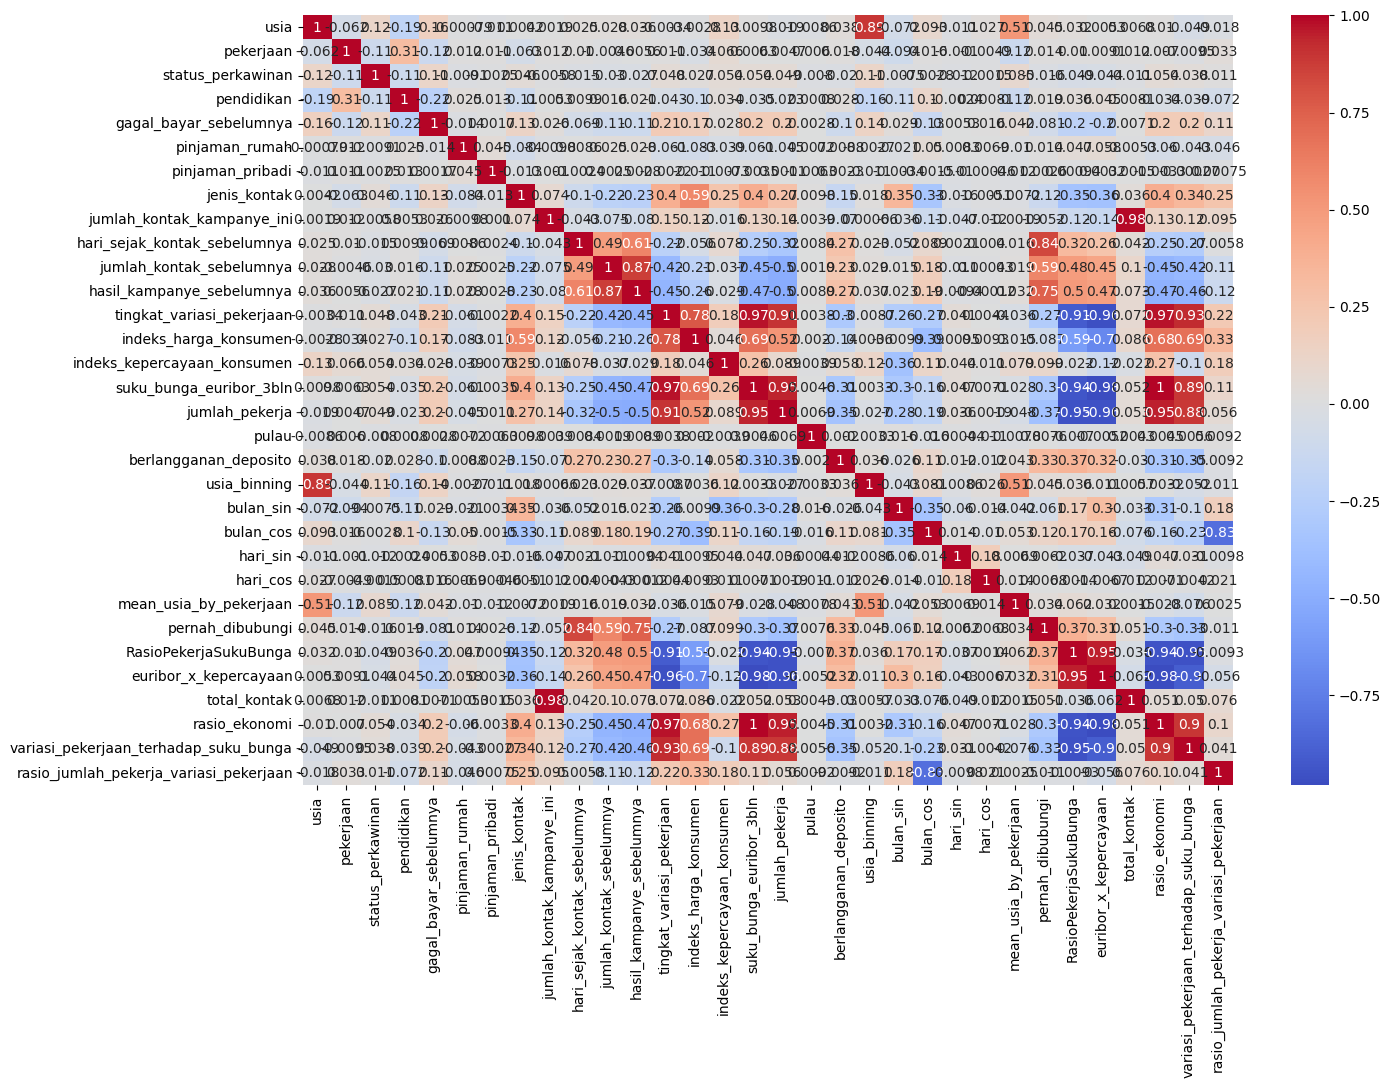

In [33]:
cc_num = cc.select_dtypes(include=np.number)
corelation_matrix = cc_num.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corelation_matrix, annot=True ,cmap='coolwarm') 

In [34]:
cc_validation.dtypes


usia                                        int64
pekerjaan                                    int8
status_perkawinan                            int8
pendidikan                                  int64
gagal_bayar_sebelumnya                       int8
pinjaman_rumah                               int8
pinjaman_pribadi                             int8
jenis_kontak                                 int8
jumlah_kontak_kampanye_ini                  int64
hari_sejak_kontak_sebelumnya                int64
jumlah_kontak_sebelumnya                    int64
hasil_kampanye_sebelumnya                   int64
tingkat_variasi_pekerjaan                 float64
indeks_harga_konsumen                     float64
indeks_kepercayaan_konsumen               float64
suku_bunga_euribor_3bln                   float64
jumlah_pekerja                            float64
pulau                                        int8
usia_binning                                 int8
bulan_sin                                 float64


In [35]:
cc.dtypes


usia                                        int64
pekerjaan                                    int8
status_perkawinan                            int8
pendidikan                                  int64
gagal_bayar_sebelumnya                       int8
pinjaman_rumah                               int8
pinjaman_pribadi                             int8
jenis_kontak                                 int8
jumlah_kontak_kampanye_ini                  int64
hari_sejak_kontak_sebelumnya                int64
jumlah_kontak_sebelumnya                    int64
hasil_kampanye_sebelumnya                   int64
tingkat_variasi_pekerjaan                 float64
indeks_harga_konsumen                     float64
indeks_kepercayaan_konsumen               float64
suku_bunga_euribor_3bln                   float64
jumlah_pekerja                            float64
pulau                                        int8
berlangganan_deposito                     float64
usia_binning                                 int8


In [36]:
cc.select_dtypes(include='object').info()

<class 'pandas.core.frame.DataFrame'>
Index: 22838 entries, 0 to 22915
Empty DataFrame


In [37]:
# cc[cc.select_dtypes(include='boolean').columns] = cc.select_dtypes(include='boolean').astype(float)

In [38]:
cc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22838 entries, 0 to 22915
Data columns (total 32 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   usia                                    22838 non-null  int64  
 1   pekerjaan                               22838 non-null  int8   
 2   status_perkawinan                       22838 non-null  int8   
 3   pendidikan                              22838 non-null  int64  
 4   gagal_bayar_sebelumnya                  22838 non-null  int8   
 5   pinjaman_rumah                          22838 non-null  int8   
 6   pinjaman_pribadi                        22838 non-null  int8   
 7   jenis_kontak                            22838 non-null  int8   
 8   jumlah_kontak_kampanye_ini              22838 non-null  int64  
 9   hari_sejak_kontak_sebelumnya            22838 non-null  int64  
 10  jumlah_kontak_sebelumnya                22838 non-null  int64  

# Modeling

In [39]:
from cuml.ensemble import RandomForestClassifier
from cuml.preprocessing import StandardScaler
from cuml.model_selection import train_test_split
from cuml.metrics import accuracy_score, roc_auc_score, confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from xgboost import plot_importance
import optuna
import cudf
import cupy as cp
import sqlite3

In [40]:
storage_url = "sqlite:////kaggle/working/DataQuest/optuna_study3.db"

In [41]:
# cc = cudf.DataFrame(cc)

In [42]:
X_train = cc.drop(columns=['berlangganan_deposito'], axis=1)
y_train = cc['berlangganan_deposito']
X_val = cc_validation

count_negative = y_train.value_counts()[0]
count_positive = y_train.value_counts()[1]
scale_pos_weight = count_negative/count_positive

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

def objective(trial):
    param = {
        'device':'cuda',     
        'predictor':'gpu_predictor',
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'booster': 'gbtree',
        'enable_categorical': True,
        'scale_pos_weight': scale_pos_weight,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 0.5),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 1.0, log=True),
        'random_state': 42
    }

    dtrain = xgb.DMatrix(X_train, label=y_train)
    cv_results = xgb.cv(
        params=param,
        dtrain=dtrain,
        num_boost_round=1000, 
        nfold=5,
        stratified=True,
        metrics={'auc'}, 
        early_stopping_rounds=35,
        seed=42,
        verbose_eval=False 
    )
    best_auc = cv_results['test-auc-mean'].max()
    optimal_boost_rounds = cv_results['test-auc-mean'].idxmax() + 1
    trial.set_user_attr('optimal_boost_rounds', optimal_boost_rounds)
    return best_auc
    

study = optuna.create_study(direction='maximize', study_name='XGboost_Study1',storage=storage_url, load_if_exists=True)
study.optimize(objective, n_trials = 100)

best_params = study.best_params
print("best parameter found from CV", best_params)

optimal_n_estimators = study.best_trial.user_attrs.get('optimal_boost_rounds', 500)
print(f"Optimal number of estimators from best trial's CV: {optimal_n_estimators}")

final_model_params = best_params.copy()
final_model_params['device'] = 'cuda'
final_model_params['predictor'] = 'gpu_predictor'
final_model_params['objective'] = 'binary:logistic' 
final_model_params['eval_metric'] = 'auc'           
final_model_params['scale_pos_weight'] = scale_pos_weight


best_model = xgb.XGBClassifier(**final_model_params, n_estimators=optimal_n_estimators, use_label_encoder=False)
best_model.fit(X_train, y_train,verbose=False)

y_pred = best_model.predict_proba(X_val)
print(y_pred[:10]) 

[I 2025-05-31 07:24:27,863] Using an existing study with name 'XGboost_Study1' instead of creating a new one.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [07:24:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "enable_categorical", "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [07:24:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "enable_categorical", "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-05-31 07:24:34,115] Trial 5140 finished with value: 0.7999875644437904 and parameters: {'learning_rate': 0.022038411437928913, 'max_depth': 4, 'min_child_weight': 8, 'gamma': 0.1365161757638701, 'subsample': 0.9157829287430268, 'colsample_bytree': 0.7197222449843879, 'reg_alpha': 0.000364887243470099, 'reg_lambda': 0.00048599139304801434}. Best is trial 5018 with value: 0.8005956525204212.
/usr/local/lib/python3.11/dist-packag

best parameter found from CV {'learning_rate': 0.021676488744070205, 'max_depth': 4, 'min_child_weight': 8, 'gamma': 0.10448964842298455, 'subsample': 0.9219298617703804, 'colsample_bytree': 0.7885893593244444, 'reg_alpha': 0.00016752124625856406, 'reg_lambda': 0.00020234561464077148}
Optimal number of estimators from best trial's CV: 213
[[0.6136515  0.38634846]
 [0.7682466  0.23175342]
 [0.8059258  0.19407423]
 [0.8115386  0.18846141]
 [0.67927873 0.32072124]
 [0.8269309  0.17306913]
 [0.70422256 0.2957774 ]
 [0.7382614  0.2617386 ]
 [0.18518502 0.814815  ]
 [0.6334168  0.36658326]]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [07:29:42] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


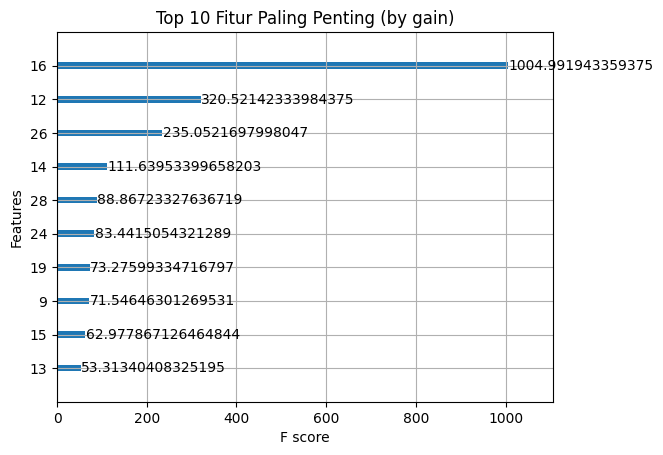

In [43]:
plot_importance(best_model, max_num_features=10, importance_type='gain')
plt.title("Top 10 Fitur Paling Penting (by gain)")
plt.show()

In [44]:
print(y_pred)
print(costumer_idval)

submission = cudf.DataFrame({'customer_number': costumer_idval ,'berlangganan_deposito': y_pred[:,1]})
submission.to_csv("DCM_DMU_2025_Model_Batok_kelapa.csv", index=False)

[[0.6136515  0.38634846]
 [0.7682466  0.23175342]
 [0.8059258  0.19407423]
 ...
 [0.836658   0.16334203]
 [0.759832   0.24016798]
 [0.731745   0.26825497]]
0       445420
1       585604
2       888824
3       816820
4       542716
         ...  
5724    782072
5725    116371
5726    773759
5727    612330
5728    986050
Name: customer_number, Length: 5729, dtype: int64
